# Gradient descent method (demo)

Author: Karim Makki

Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. It is the basic technique to minimize cost function in neural networks (a function of weigths and bias). The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent.

# Remarks

* We show that if the learning rate is a function of the curvature of the cost function (in particular the intrinsic cuvature), then the gradient descent algorithm converges more fastly toward the optimal solution

* For now, we suppose that the cost function is a continuously differentiable and convex function.

* Throughout the notebook, we will note the multi-variable cost function by $z$

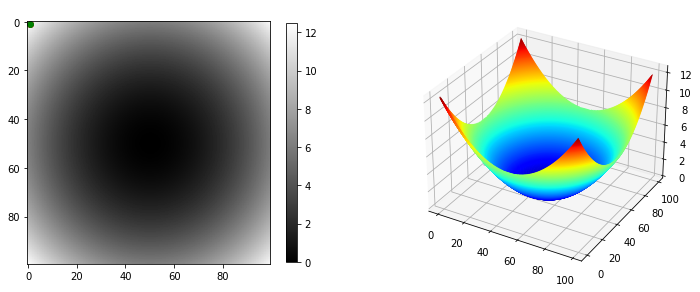

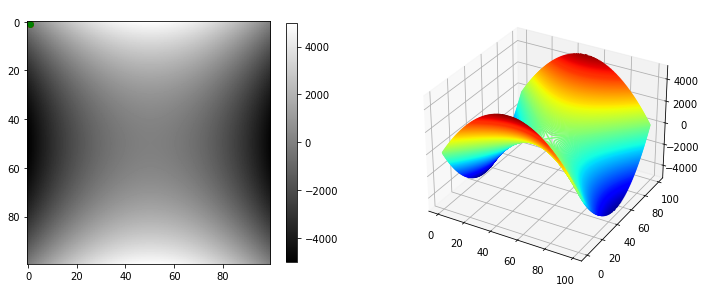

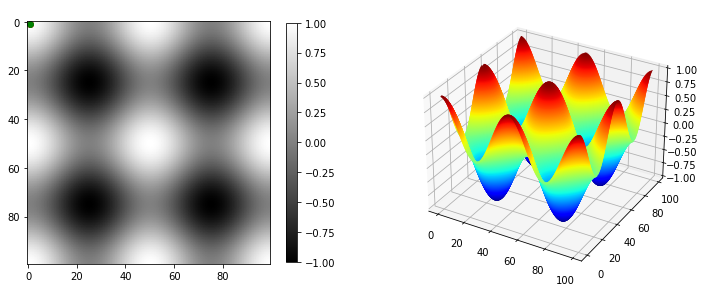

In [152]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math


def parabola(a, b, dim):
    z = np.zeros((dim,dim))
    for x in range(dim):
        for y in range(dim):
            z[x,y]= ((x-dim/2)/a)**2 + ((y-dim/2)/b)**2 
    return z 


def hyperbola(a, dim):
    z = np.zeros((dim,dim))
    for x in range(dim):
        for y in range(dim):
            z[x,y]= a*(x-dim/2)**2 - a*(y-dim/2)**2 
    return z

def surf(K, dim):
    z = np.zeros((dim,dim))
    for x in range(dim):
        for y in range(dim):
            X = x/dim
            Y= y/dim
            z[x,y]= 0.5* (math.cos(2*math.pi*K*X)+math.cos(2*math.pi*K*Y)) 
    return z

def draw_3d(z, feature, point_in=[1,1], point_out=[1,1]):
    
    x, y = np.meshgrid(range(z.shape[0]), range(z.shape[1]))
    fig = plt.figure(figsize=(12, 5))
    ax1 = plt.subplot(121)
    ax1.scatter(point_in[0], point_in[1], c = 'red')
    ax1.scatter(point_out[0], point_out[1], c = 'green')
    
    pos = ax1.imshow(z, cmap="gray")
    ax2 = plt.subplot(122, projection='3d')
    ax2.contour3D(x, y, feature, 300, cmap='jet')
    fig.colorbar(pos,ax=ax1,shrink=0.88)
    
    fig.savefig('./parabola.pdf')
    
z = parabola(20,20,100)
draw_3d(z, z)
    
z = hyperbola(2,100)
draw_3d(z, z)

z = surf(2,100)
draw_3d(z, z)
    



# Estimate curvature of the cost function

$\kappa = \frac{\nabla z \nabla^2_* z \nabla z ^T}{|\nabla z|^4}$

-0.012978509208581568


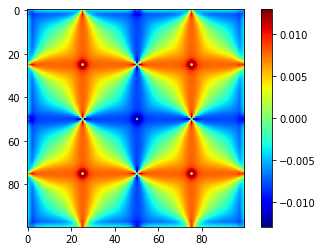

In [153]:
from scipy.ndimage.filters import gaussian_filter

def hessian(f):

    f_grad = np.gradient(f)
    hessian = np.empty((f.ndim, f.ndim) + f.shape, dtype=f.dtype)
    for k, grad_k in enumerate(f_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl

    return f_grad, hessian


def L2_norm_grad(gx,gy):

    norm_grad =  np.sqrt(np.square(gx)+np.square(gy))
    gaussian_filter(norm_grad, sigma=1, output=norm_grad)
    norm_grad[np.where(norm_grad==0)]=1 # just to avoid dividing by zero

    return  norm_grad

def Gaussian_curvature(f_grad,H):

    gx, gy = f_grad
    norm = L2_norm_grad(gx,gy)
    gx /= norm
    gy /= norm

    gaussian_curv =  gx**2 * H[1,1,...] + gy**2 * H[0,0,...] - gx*gy * \
    (H[0,1,...]+H[1,0,...])
    
    np.divide(gaussian_curv,L2_norm_grad(gx,gy)**4,gaussian_curv)
    

    return gaussian_curv

G, H = hessian(z)

g_curv = Gaussian_curvature(G,H)

plt.imshow(g_curv, cmap='jet')
plt.colorbar()
plt.show

print(np.min(g_curv))

# Compute $\kappa_m = \frac{1}{2} \nabla \cdot \frac{\nabla z}{|\nabla z|} $
, also known as the divergence formula to estimate mean curvature of an $n$-isosurface, embedded in $(n+1)$-dimensional Eulidean space

The idea is to consider the multivariable cost function as the zero level set of a signed distance function of higher dimensional space.

0.09090909090909091 0.1


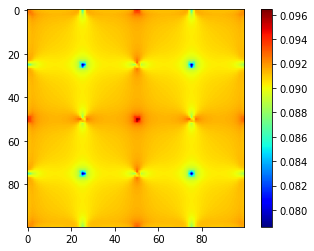

In [154]:

import sys


def norm_grad_nD(f):
    
    norm_grad = np.zeros(f.shape)
    grad_f = np.gradient(f)
    
    for i, grad_f_i in enumerate(grad_f):
        norm_grad += grad_f_i**2 
    
    norm_grad[np.where(norm_grad==0)] = sys.float_info.epsilon # To avoid dividing by zero later 
    
        
    return grad_f, np.sqrt(norm_grad)
    
        

def divergence_formula(grad_f, grad_norm_f):
    
    mean_curv = np.zeros(grad_norm_f.shape)
    
    for i, grad_f_i in enumerate(grad_f):
        
        grad_f_ii = np.gradient( np.divide(grad_f_i,grad_norm_f), axis=i )
        
        mean_curv += grad_f_ii
    
    return 0.5 * mean_curv
        
    
    
grad_f, norm_grad = norm_grad_nD(z)
mean_curv = divergence_formula(grad_f, norm_grad)

alpha_x = 1/(10+mean_curv**2)
print(np.min(alpha_x), np.max(alpha_x))

plt.imshow(1/(10+np.exp(mean_curv)), cmap='jet')
plt.colorbar()
#plt.clim(0.08,0.099)
plt.show()





The gradient descent method is based on the observation that if the multi-variable function $z(x)$ ($x \in \mathbb{R}^n$) is defined and differentiable in a neighborhood of a point $a$, then $z(x)$ decreases fastest if one goes from $a$ in the direction of the negative gradient of $z$ at a , $- \nabla z(a)$. In general, the problem is solved iteratively until an elliptic point on the surface is reached, i.e. a local or global (in the best case) minimum can be reached after a certain number of iterations when $\alpha$ is a small real constant. A local/global maximum is achieved if we proceed by gradient ascent and the principle remains the same by just inverting the sign of $\alpha$. It follows that:

$x_{n+1}= x_n - \alpha \nabla z(x_n)$

In [155]:
#########Implementation of the gradient descent method ######################
#Prameters:
#  * cur_x: The algorithm starts at x=cur_x
#  * alpha: Learning rate
#  * precision: This tells us when to stop the algorithm
#  * previous_step_size 
#  * max_iters: maximum number of iterations
#  * cost_function: function to be minimized
#  * method: conventional or our method


def gradient_descent(cur_x, alpha, precision, previous_step_size, max_iters,\
                     cost_function, method):
    
    iters = 0 #iteration counter
    
    if (method == 'gauss_curv'):
        G, H = hessian(cost_function)
        g_curv = Gaussian_curvature(G,H)
        
    elif (method == 'mean_curv'):
        grad_f, norm_grad = norm_grad_nD(cost_function)
        mean_curv = divergence_formula(grad_f, norm_grad)
        
    else:
        pass
        
    
    Gx, Gy = np.gradient(cost_function)
        

    while previous_step_size > precision and iters < max_iters:
        prev_x = cur_x #Store current x value in prev_x
    
        
        if (method=="gauss_curv"):

        ### Grad descent: our method

            cur_x = cur_x - 10*g_curv[int(prev_x[0]),int(prev_x[1])] * np.array(\
                    [Gx[int(prev_x[0]),\
                    int(prev_x[1])],Gy[int(prev_x[0]),int(prev_x[1])]])
            
        elif (method=="mean_curv"):

        ### Grad descent: our method
            alpha_x = 1/(10+mean_curv[int(prev_x[0]),int(prev_x[1])]**2)

            cur_x = cur_x - alpha_x * np.array(\
                    [Gx[int(prev_x[0]),\
                    int(prev_x[1])],Gy[int(prev_x[0]),int(prev_x[1])]])
        else:
           ### Grad descent: conventional method
            cur_x = cur_x - alpha * np.array([Gx[int(prev_x[0]),int(prev_x[1])],\
            Gy[int(prev_x[0]),int(prev_x[1])]])  #Grad descent         


        previous_step_size = np.max(np.absolute(cur_x - prev_x)) #Change in x
        iters += 1 #iteration count
        #print("Iteration",iters,"\nX value is",cur_x) #Print iterations
    print("The algorithm converges at iteration",iters)

    print("The local minimum occurs at", cur_x)
    
    return cur_x

In the following, we show an exemple for a convex function (paraboloid), using two different choices for the learning rate $\alpha$.

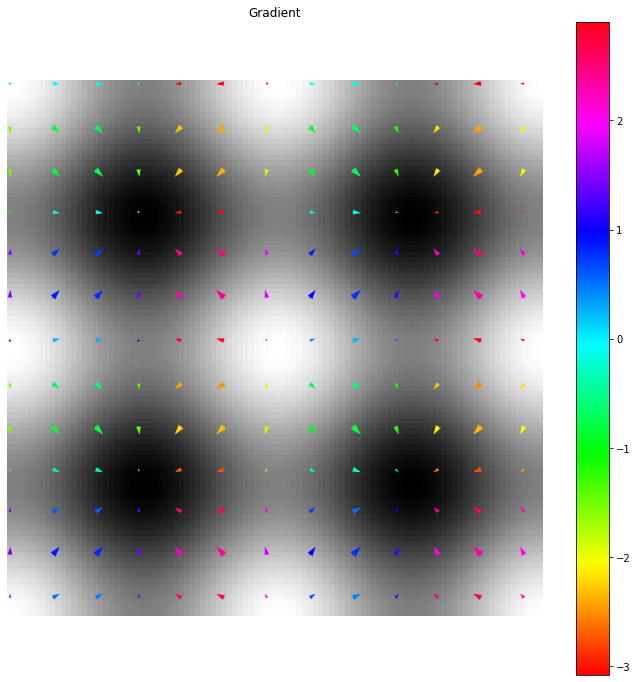

In [156]:
R = np.where(np.logical_or(z!=0, z==0))

def plot_gradient(Nx,Ny,R,z,title):

    x, y = R[0],R[1]
    step = 8
        # grid downsampling
    xn = np.extract(np.logical_and(np.mod(x, step)==0,np.mod(y, step)==0), x)
    yn = np.extract(np.logical_and(np.mod(x, step)==0,np.mod(y, step)==0), y)
    vx = Nx[xn,yn]
    vy = Ny[xn,yn]
    
    fig = plt.figure(figsize=(12, 12))
    plt.axis("equal")
    plt.imshow(z, cmap=plt.cm.gray)
    plt.quiver(yn, xn, vy,vx, - np.arctan2(vx, vy), angles='xy',\
     units = 'inches', cmap='hsv', scale_units='xy', scale=0.04)
    plt.colorbar()#orientation="horizontal")
    plt.axis('off')
    plt.title(title)
    #plt.savefig("./gradient_vector_field.png",dpi=500)
    plt.show()

Gx, Gy = np.gradient(z)
plot_gradient(-Gx,-Gy,R, z, "Gradient")


# Case 1: a small learning rate $\alpha = cste = 10^{-2}$

In [157]:

optimum = gradient_descent(cur_x=np.array([1.0,1.0]), alpha=0.01, \
        precision=0.00001, previous_step_size=1,\
        max_iters=100000, cost_function=z, method=None)


The algorithm converges at iteration 84936
The local minimum occurs at [25.00004107 25.00004107]


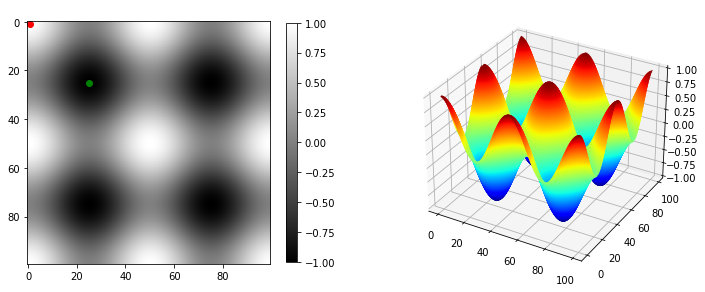

In [158]:
draw_3d(z, z, [1.0,1.0],[optimum[0], optimum[1]])

# Case 2:  choose $\alpha$ as a function of the curvature (the Hessian adjoint of the cost function)

$\alpha = 10.\kappa(x)$ where $\kappa = \frac{\nabla z \nabla^2_* z \nabla z ^T}{|\nabla z|^4}$ and $\nabla^2_*$ is the adjoint of the Hessian operator $\nabla ^2$. Note that alpha is still of the order of $10^{-2}$ to perform objective comparison with the fixed $\alpha = 10^{-2}$, used previously

In [159]:
optimum = gradient_descent(cur_x=np.array([20.0,20.0]), alpha=0.01,\
          precision=0.00001, previous_step_size=1,\
          max_iters=100000, cost_function=z, method='gauss_curv')

The algorithm converges at iteration 3146
The local minimum occurs at [25.00099764 25.00099764]


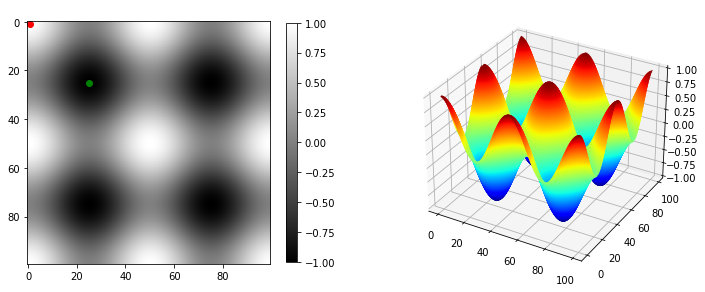

In [160]:
draw_3d(z, z, [1.0,1.0],[optimum[0], optimum[1]])

# Case 3:  choose $\alpha$ as a function of the mean curvature (divergence formula)

* Curvature driven gradient descent (here we use extrinsic curvature)

$\alpha(x) = \frac{1}{1+10.exp(\kappa_m(x))}$


In [163]:
optimum = gradient_descent(cur_x=np.array([20.0,20.0]), alpha=0.01,\
          precision=0.00001, previous_step_size=1,\
          max_iters=100000, cost_function=z, method='mean_curv')

The algorithm converges at iteration 2980
The local minimum occurs at [25.00028736 25.00028736]


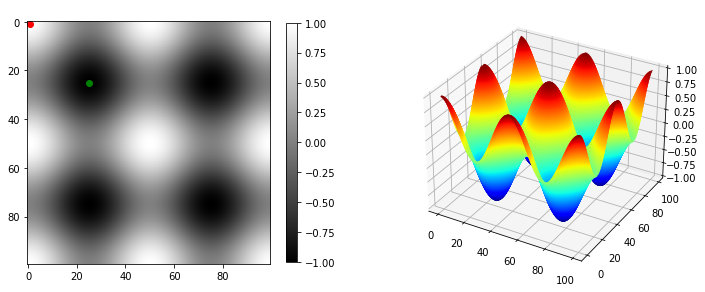

In [164]:
draw_3d(z, z, [1.0,1.0],[optimum[0], optimum[1]])

# Conclusions: 
* When choosing $\alpha=cste$ , the gradient descent algorithm converges after $89583$ iterations, but when using a curvature-based learning rate (modulo scale, e.g. here we use a scale factor of $10$, anyway, this choice can be based on curvature range of values), the gradient descent algorithm converges after only $13814$ iterations. It goes 6 times faster for this example!   
* Be careful, your cost function should be continuously twice differentiable (to be able to compute both its gradient and more particularly its Hessian/ second derivative). Hopefully, cost functions are distance-like functions generally, thus they can be twice-differentiated with a higher confidence (this is to be verified experimentally). 
* The main limitation of the gradient descent method, is that the convergence time is highly dependent on the starting point, which is generally a random process. Unfortunately this issue cannot be easily handled but it can be the object of a new notebook!


This notebook, and more is available on Github at: https://github.com/k16makki/Medima_tools

# Enjoy!
